# Imports

In [38]:
import os
import pandas as pd

# configs
from configs.paths import TRAIN_DATA_PATH, TEST_DATA_PATH, SCORES_2014, SCORES_2020, MODEL_DIR
from configs.constants import RANDOM_SEED, TEST_SAMPLE_SIZE, CROSS_VALIDATION_SPLITS

# tournaments
from tournaments.data_cleaning import get_all_tournament_data
from tournaments.feature_engineering import create_features_tournament, add_scores

# scores
from scores.data_cleaning import get_combined_scores
from scores.feature_engineering import create_features_scores
from scores.data_plotting import plot_scores

# utils
from utils.name_mapping import get_name_mapping, map_name_to_players

# preprocessing
from preprocessing.data_pipeline import _keep_features_and_dependent_columns, process_data

# plotting
from plotting.distributions import plot_winner_distribution, plot_correlogram


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scores

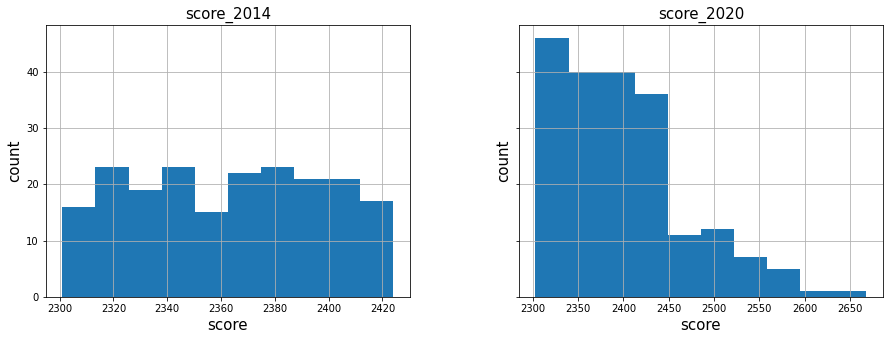

In [2]:
df_scores_raw = get_combined_scores(SCORES_2014, SCORES_2020)
plot_scores(df_scores_raw)

# Tournaments

## Data cleaning

In [40]:
df_tournament_raw = get_all_tournament_data(TRAIN_DATA_PATH, True)

In [4]:
df_tournament_raw

,tournament_id,tour_id,game_id,start_date,end_date,date,time_control,white,black,result,num_tours
0,1,1,1,2014-01-08,2014-01-17,2014-01-08,rapid,贾叶珍,范辰妮,0.5,9
1,1,1,2,2014-01-08,2014-01-17,2014-01-08,rapid,吕亚光,李嘉爵,0.5,9
2,1,1,3,2014-01-08,2014-01-17,2014-01-08,rapid,刘奇喜,刘晓鹏,0.5,9
3,1,1,4,2014-01-08,2014-01-17,2014-01-08,rapid,陆桂姐,郑新聪,1.0,9
4,1,1,5,2014-01-08,2014-01-17,2014-01-08,rapid,李汶玲,叶天英,0.5,9
...,...,...,...,...,...,...,...,...,...,...,...
174113,803,8,164,2019-12-28,2019-12-28,2019-12-28,classic,Yang Ling,Feng Sanli,1.0,8
174114,803,8,165,2019-12-28,2019-12-28,2019-12-28,classic,Xiong Shuxian,Wang Yabao,0.0,8
174115,803,8,166,2019-12-28,2019-12-28,2019-12-28,classic,Huang Mengli,Wang Jiajuan,0.0,8
174116,803,8,167,2019-12-28,2019-12-28,2019-12-28,classic,Cheng Momei,Xu Fuying,0.5,8


## Data quality

In [41]:
def check_if_same_player_is_present_in_multiple_games_within_tour(df_orig: pd.DataFrame):
    def _is_present(df_agg):
        players = df_agg.reindex(columns=['white','black']).stack().tolist()
        return len(players) != len(set(players))
    df = df_orig.copy()
    df_agg = df.groupby(['tournament_id','tour_id']).apply(_is_present).unique().tolist()
    return df_agg

def check_if_there_is_other_punctuation(df: pd.DataFrame) -> bool:
    names = df.reindex(columns=['white','black']).stack().str.replace(',','')
    return names.str.contains(r'[^\w\s]').unique().tolist()


summary = {
    'same_player_multiple_games_in_tour': check_if_same_player_is_present_in_multiple_games_within_tour(df_tournament_raw),
    'other_punctuation_in_names': check_if_there_is_other_punctuation(df_tournament_raw),
}
summary


{'same_player_multiple_games_in_tour': [False, True],
 'other_punctuation_in_names': [False]}

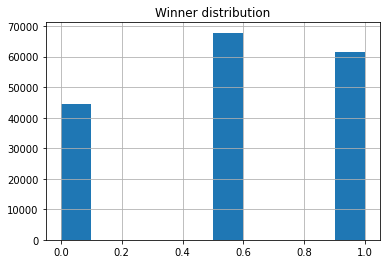

In [42]:
plot_winner_distribution(df_tournament_raw['result'])

In [52]:
result_distribution = df_tournament_raw.groupby('result')['tournament_id'].count().rename('distribution').reset_index()
result_distribution['percentage'] = (100 * result_distribution['distribution'] / result_distribution['distribution'].sum()).round(2)
result_distribution

,result,distribution,percentage
0,0.0,44640,25.64
1,0.5,67835,38.96
2,1.0,61643,35.40


## Feature engineering

In [7]:
df_scores = create_features_scores(df_scores_raw)
df_tournament = create_features_tournament(df_tournament_raw)
df = add_scores(df_tournament, df_scores)

### Might try adding history, skip for now

In [8]:
from tqdm.notebook import tqdm

def _get_previous_indices(pair, idx, df):
    df_filtered = df[df.index < idx]
    result = df_filtered.loc[df_filtered['pair'] == pair['pair'], :]
    result = [] if result.empty else result.index.tolist()
    df.loc[idx, 'previous_indices'] = str(result)
    return df

def _add_previous_indices(df):
    df['pair'] = df.reindex(columns=['white','black']).agg(tuple, axis=1).apply(sorted).apply(', '.join)
    for idx, pair in tqdm(df.iterrows()):
        df = _get_previous_indices(pair, idx, df)
    df['previous_indices'] = df['previous_indices'].fillna('').str.strip('[]').str.split(', ')
    df = df.drop(columns=['pair'])
    return df
    

## Features

In [9]:
df.describe()

,tournament_id,game_id,result,num_players,is_classic,is_knockout,is_swiss,is_round_robin,tour_completion,tournament_completion,white_score_2014,white_score_2020,black_score_2014,black_score_2020
count,174118.000000,174118.000000,174118.000000,174118.000000,174118.000000,174118.000000,174118.000000,174118.0,174118.000000,174118.000000,174118.000000,174118.000000,174118.000000,174118.000000
mean,396.078366,140.251467,0.097652,55.825923,0.410595,0.102752,0.897248,0.0,0.523019,0.279134,597.464128,601.435549,597.519406,601.209829
std,230.316091,100.027688,0.775162,28.710740,0.491943,0.303636,0.303636,0.0,0.289481,0.288688,1026.517562,1038.663587,1026.533845,1038.559085
min,1.000000,1.000000,-1.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000
25%,196.000000,57.000000,-1.000000,42.000000,0.000000,0.000000,1.000000,0.0,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,393.000000,124.000000,0.000000,56.000000,0.000000,0.000000,1.000000,0.0,0.500000,0.190476,0.000000,0.000000,0.000000,0.000000
75%,597.000000,206.000000,1.000000,64.000000,1.000000,0.000000,1.000000,0.0,0.777778,0.521739,2302.000000,2303.000000,2302.000000,2303.000000
max,803.000000,582.000000,1.000000,256.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.909091,2424.000000,2668.000000,2424.000000,2668.000000


Excluded features:
- tournament_id: id column
- game_id: id column

Created features:
- white: player names are mapped to generic ids
- black: player names are mapped to generic ids
- is_classic: 1 if classic tournament type, 0 otherwise
- is_knockout: derived based on number of players and tours; 1 if knockout type, 0 otherwise
    - is_round_robin: always 0, thus, excluded
    - is_swiss: opposite to knockout, excluded
- tour_completion: ratio of the current tour and total tours in the tournament
- tournament_completion: ratio of days since tournament start and total allocated days
- white_score_2014: rating of white player according ELO 2014
- white_score_2020: rating of white player according ELO 2020
- black_score_2014: rating of black player according ELO 2014
- black_score_2020: rating of black player according ELO 2020

In [11]:
df_features = _keep_features_and_dependent_columns(df)

In [12]:
df_features

,white,black,is_classic,is_knockout,tour_completion,tournament_completion,white_score_2014,white_score_2020,black_score_2014,black_score_2020,result
0,player_0,player_195,0,0,0.111111,0.0,0,0,0,0,0
1,player_65,player_224,0,0,0.111111,0.0,0,0,0,0,0
2,player_318,player_438,0,0,0.111111,0.0,0,0,0,0,0
3,player_408,player_381,0,0,0.111111,0.0,0,0,0,0,1
4,player_187,player_1,0,0,0.111111,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
174113,player_845,player_708,1,0,1.000000,0.0,0,2307,2384,0,1
174114,player_305,player_760,1,0,1.000000,0.0,0,0,2362,0,-1
174115,player_479,player_394,1,0,1.000000,0.0,0,0,0,0,-1
174116,player_264,player_298,1,0,1.000000,0.0,0,0,0,0,0


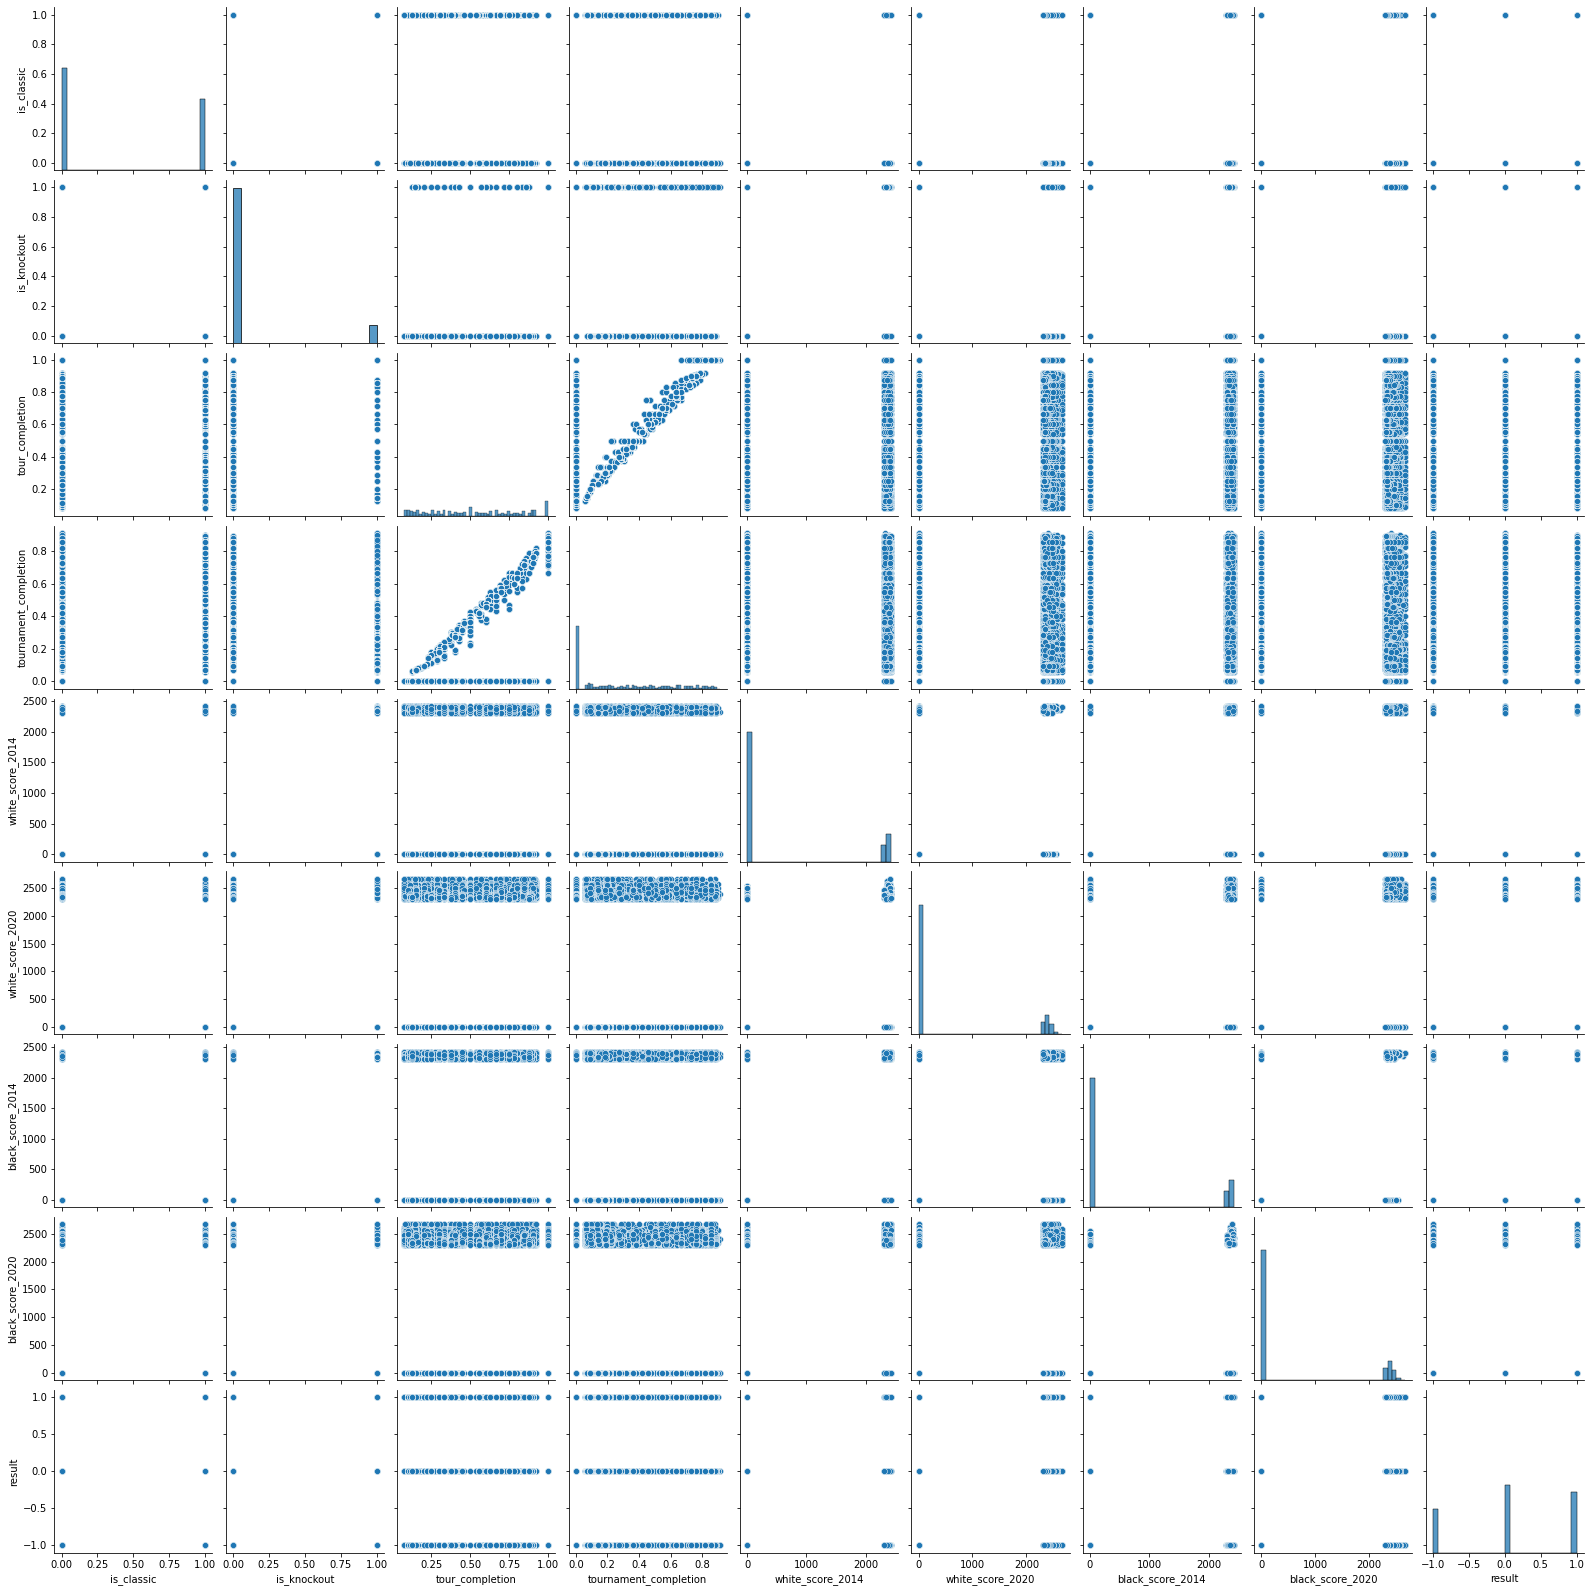

In [13]:
plot_correlogram(df_features)

## Evaluation

In [4]:
X, y = process_data(TRAIN_DATA_PATH)

In [36]:
from models.baseline_models.white_wins import WhiteWinsModel
from models.baseline_models.black_wins import BlackWinsModel
from models.baseline_models.draw import DrawModel
from models.baseline_models.random_winner import RandomWinnerModel

from models.advanced_models.random_forest import RandomForestModel

from models.operations.evaluation import evaluate_models
from models.operations.training import train_models
from models.operations.saving import save_models

metrics = ['accuracy', 'recall_macro', 'f1_macro']

baseline_models = [
    WhiteWinsModel(),
    BlackWinsModel(),
    DrawModel(),
    RandomWinnerModel(),
]

advanced_models = [
    RandomForestModel(n_epochs = 100, batch_size = 1024),
]

models = baseline_models + advanced_models

train_models(models, X, y)

tuned_models_and_params = [model.tune_hyperparameters(X, y) for model in models]
tuned_models = [model for model, _ in tuned_models_and_params if model is not None]
models += tuned_models

In [ ]:
best_params = {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40}

In [ ]:
save_models(models)

In [ ]:
evaluations = evaluate_models(models, X, y, metrics)

In [35]:
evaluations

fold_0      fold_1  \
model                   score_type metric                                 
WhiteWinsModel          NaN        fit_time        2.335045    2.333013   
                                   score_time      0.344024    0.376128   
                        test       accuracy        0.354032    0.354032   
                                   f1_macro        0.174310    0.174310   
                                   recall_macro    0.333333    0.333333   
                        train      accuracy        0.354029    0.354029   
                                   f1_macro        0.174309    0.174309   
                                   recall_macro    0.333333    0.333333   
BlackWinsModel          NaN        fit_time        2.333400    2.339910   
                                   score_time      0.348204    0.383961   
                        test       accuracy        0.256375    0.256375   
                                   f1_macro        0.136039    0.136039   
                                   recall_macro    0.333333    0.333333   
                        train      accuracy        0.256379    0.256379   
                                   f1_macro        0.136041    0.136041   
                                   recall_macro    0.333333    0.333333   
DrawModel               NaN        fit_time        2.306811    2.311000   
                                   score_time      0.360275    0.386573   
                        test       accuracy        0.389593    0.389593   
                                   f1_macro        0.186910    0.186910   
                                   recall_macro    0.333333    0.333333   
                        train      accuracy        0.389592    0.389592   
                                   f1_macro        0.186909    0.186909   
                                   recall_macro    0.333333    0.333333   
RandomWinnerModel       NaN        fit_time        2.331176    2.377313   
                                   score_time      0.340841    0.391062   
                        test       accuracy        0.333678    0.329635   
                                   f1_macro        0.330977    0.327228   
                                   recall_macro    0.333290    0.329793   
                        train      accuracy        0.332557    0.334709   
                                   f1_macro        0.330114    0.332076   
                                   recall_macro    0.332675    0.334471   
RandomForestModel       NaN        fit_time      275.694943  281.566628   
                                   score_time    457.550884  453.645170   
                        test       accuracy        0.424397    0.427223   
                                   f1_macro        0.325659    0.325776   
                                   recall_macro    0.376670    0.378718   
                        train      accuracy        0.435239    0.434887   
                                   f1_macro        0.334965    0.334955   
                                   recall_macro    0.386511    0.386251   
RandomForestModel_tuned NaN        fit_time      146.015156  144.944036   
                                   score_time    217.463084  217.374815   
                        test       accuracy        0.417115    0.417781   
                                   f1_macro        0.289237    0.289155   
                                   recall_macro    0.364216    0.364714   
                        train      accuracy        0.418277    0.418944   
                                   f1_macro        0.289909    0.291306   
                                   recall_macro    0.365221    0.365925   

                                                     fold_2        mean  \
model                   score_type metric                                 
WhiteWinsModel          NaN        fit_time        2.351127    2.339728   
                                   score_time      0.362965    0.361039   
  

Assumptions
- maximum score is taken if there are multiple scores per person
- players with missing scores are assigned a score of 0

Limitations
- Names are not checked for spelling errors
- Historical games between the same opponents are not explicitly accounted for
    - Data is not treated as time series
    - Data is not treated as sequence of games
- Neither of the current features show promissing correlation with the results
- Future events have impact on past events (e.g., score_2020 on games played in 2014)
